# Fit and Predict Credit Information


I am going to fit and predit credit information of a competition, "Home Credit Default Risk" on Kaggle.

In [1]:
import pandas as pd
import missingno as msno
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
#from sklearn.model_selection import train_test_split
import lightgbm as lgb
from sklearn.metrics import roc_auc_score
from sklearn.model_selection import KFold


### Train Dataset

In [2]:
# get the train dataset

train = pd.read_csv('application_train.csv')

#train = train.sample(40000)

In [3]:
# grasp the contents of the train dataset

train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 307511 entries, 0 to 307510
Columns: 122 entries, SK_ID_CURR to AMT_REQ_CREDIT_BUREAU_YEAR
dtypes: float64(65), int64(41), object(16)
memory usage: 286.2+ MB


In [91]:
train.dtypes

SK_ID_CURR                      int64
TARGET                          int64
NAME_CONTRACT_TYPE             object
CODE_GENDER                    object
FLAG_OWN_CAR                   object
FLAG_OWN_REALTY                object
CNT_CHILDREN                    int64
AMT_INCOME_TOTAL              float64
AMT_CREDIT                    float64
AMT_ANNUITY                   float64
AMT_GOODS_PRICE               float64
NAME_TYPE_SUITE                object
NAME_INCOME_TYPE               object
NAME_EDUCATION_TYPE            object
NAME_FAMILY_STATUS             object
NAME_HOUSING_TYPE              object
REGION_POPULATION_RELATIVE    float64
DAYS_BIRTH                      int64
DAYS_EMPLOYED                   int64
DAYS_REGISTRATION             float64
DAYS_ID_PUBLISH                 int64
OWN_CAR_AGE                   float64
FLAG_MOBIL                      int64
FLAG_EMP_PHONE                  int64
FLAG_WORK_PHONE                 int64
FLAG_CONT_MOBILE                int64
FLAG_PHONE  

In [4]:
train.describe()

,SK_ID_CURR,TARGET,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,AMT_GOODS_PRICE,REGION_POPULATION_RELATIVE,DAYS_BIRTH,DAYS_EMPLOYED,...,FLAG_DOCUMENT_18,FLAG_DOCUMENT_19,FLAG_DOCUMENT_20,FLAG_DOCUMENT_21,AMT_REQ_CREDIT_BUREAU_HOUR,AMT_REQ_CREDIT_BUREAU_DAY,AMT_REQ_CREDIT_BUREAU_WEEK,AMT_REQ_CREDIT_BUREAU_MON,AMT_REQ_CREDIT_BUREAU_QRT,AMT_REQ_CREDIT_BUREAU_YEAR
count,307511.000000,307511.000000,307511.000000,3.075110e+05,3.075110e+05,307499.000000,3.072330e+05,307511.000000,307511.000000,307511.000000,...,307511.000000,307511.000000,307511.000000,307511.000000,265992.000000,265992.000000,265992.000000,265992.000000,265992.000000,265992.000000
mean,278180.518577,0.080729,0.417052,1.687979e+05,5.990260e+05,27108.573909,5.383962e+05,0.020868,-16036.995067,63815.045904,...,0.008130,0.000595,0.000507,0.000335,0.006402,0.007000,0.034362,0.267395,0.265474,1.899974
std,102790.175348,0.272419,0.722121,2.371231e+05,4.024908e+05,14493.737315,3.694465e+05,0.013831,4363.988632,141275.766519,...,0.089798,0.024387,0.022518,0.018299,0.083849,0.110757,0.204685,0.916002,0.794056,1.869295
min,100002.000000,0.000000,0.000000,2.565000e+04,4.500000e+04,1615.500000,4.050000e+04,0.000290,-25229.000000,-17912.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,189145.500000,0.000000,0.000000,1.125000e+05,2.700000e+05,16524.000000,2.385000e+05,0.010006,-19682.000000,-2760.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,278202.000000,0.000000,0.000000,1.471500e+05,5.135310e+05,24903.000000,4.500000e+05,0.018850,-15750.000000,-1213.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000
75%,367142.500000,0.000000,1.000000,2.025000e+05,8.086500e+05,34596.000000,6.795000e+05,0.028663,-12413.000000,-289.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,3.000000
max,456255.000000,1.000000,19.000000,1.170000e+08,4.050000e+06,258025.500000,4.050000e+06,0.072508,-7489.000000,365243.000000,...,1.000000,1.000000,1.000000,1.000000,4.000000,9.000000,8.000000,27.000000,261.000000,25.000000


In [5]:
# check whether each feature value has missing values of the train dataset

n_missing_values = train.isnull().sum().drop("SK_ID_CURR").drop("TARGET")

n_missing_values_table = pd.DataFrame({
    'missing_values': n_missing_values
})

n_missing_values_table

,missing_values
NAME_CONTRACT_TYPE,0
CODE_GENDER,0
FLAG_OWN_CAR,0
FLAG_OWN_REALTY,0
CNT_CHILDREN,0
AMT_INCOME_TOTAL,0
AMT_CREDIT,0
AMT_ANNUITY,12
AMT_GOODS_PRICE,278
NAME_TYPE_SUITE,1292


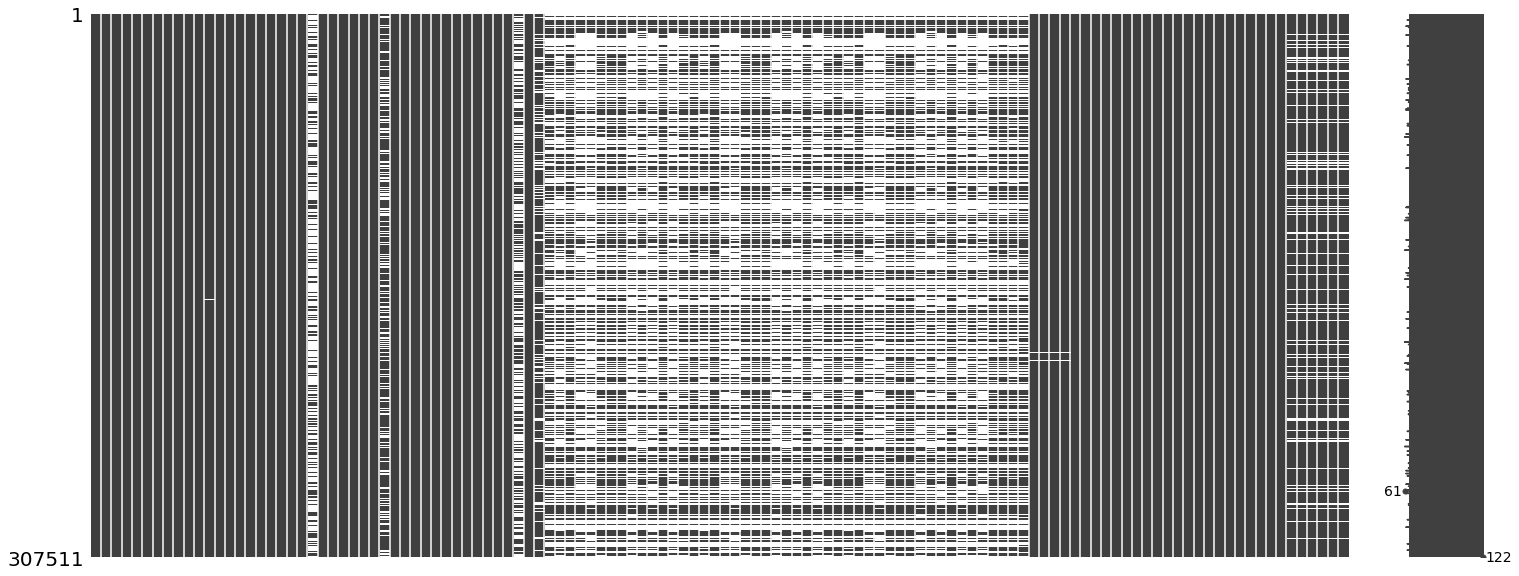

In [6]:
msno.matrix(train)

plt.show()

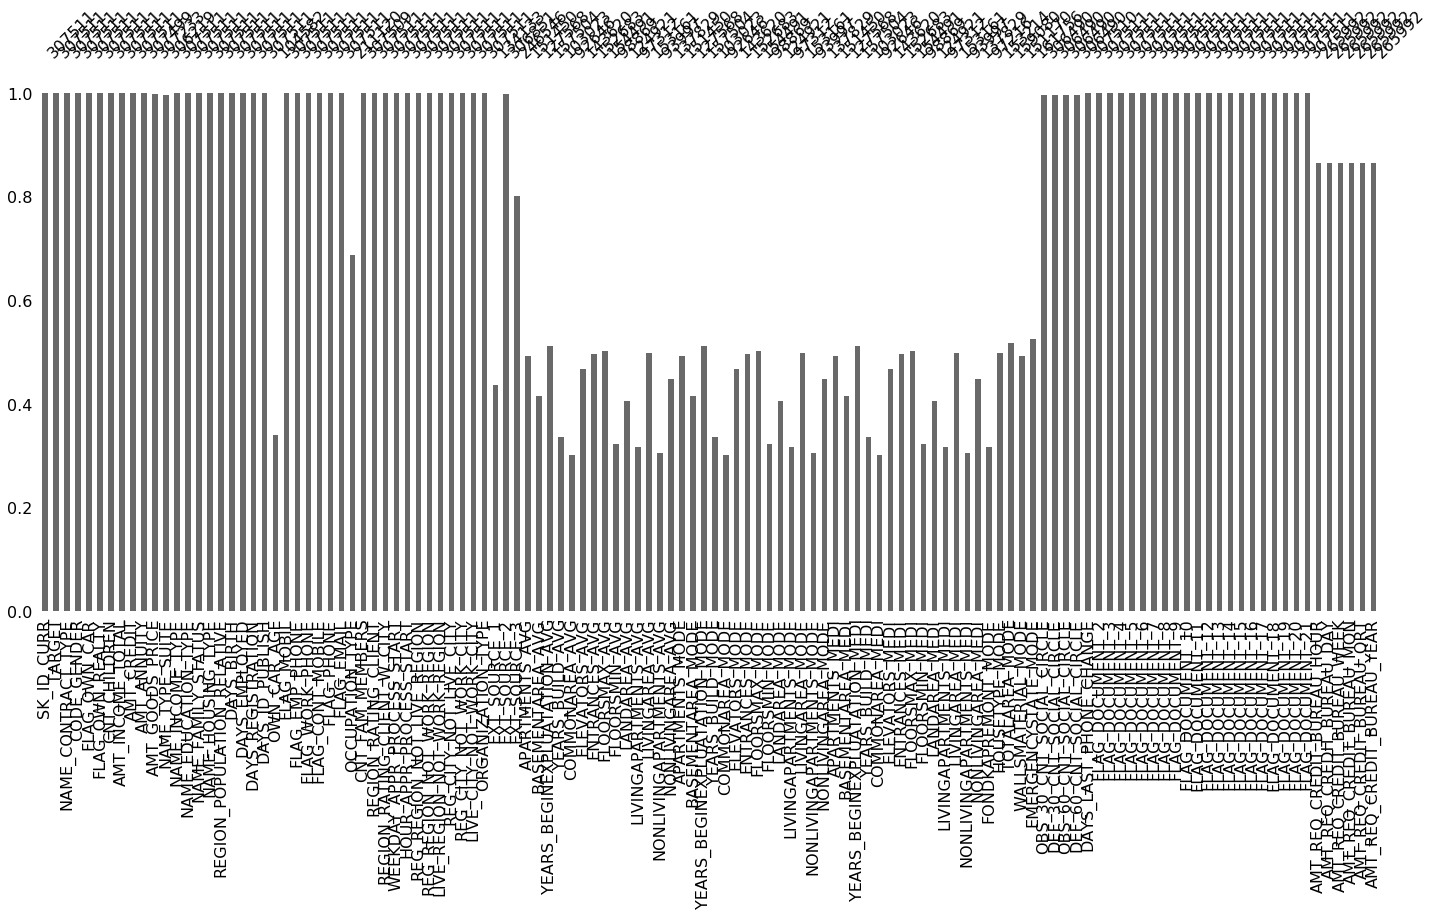

In [7]:
msno.bar(train)

plt.show()

### Test Dataset

In [8]:
# get the test dataset

test = pd.read_csv('application_test.csv')

test

,SK_ID_CURR,NAME_CONTRACT_TYPE,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,AMT_GOODS_PRICE,...,FLAG_DOCUMENT_18,FLAG_DOCUMENT_19,FLAG_DOCUMENT_20,FLAG_DOCUMENT_21,AMT_REQ_CREDIT_BUREAU_HOUR,AMT_REQ_CREDIT_BUREAU_DAY,AMT_REQ_CREDIT_BUREAU_WEEK,AMT_REQ_CREDIT_BUREAU_MON,AMT_REQ_CREDIT_BUREAU_QRT,AMT_REQ_CREDIT_BUREAU_YEAR
0,100001,Cash loans,F,N,Y,0,135000.0,568800.0,20560.5,450000.0,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0
1,100005,Cash loans,M,N,Y,0,99000.0,222768.0,17370.0,180000.0,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,3.0
2,100013,Cash loans,M,Y,Y,0,202500.0,663264.0,69777.0,630000.0,...,0,0,0,0,0.0,0.0,0.0,0.0,1.0,4.0
3,100028,Cash loans,F,N,Y,2,315000.0,1575000.0,49018.5,1575000.0,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,3.0
4,100038,Cash loans,M,Y,N,1,180000.0,625500.0,32067.0,625500.0,...,0,0,0,0,NaN,NaN,NaN,NaN,NaN,NaN
5,100042,Cash loans,F,Y,Y,0,270000.0,959688.0,34600.5,810000.0,...,0,0,0,0,0.0,0.0,0.0,0.0,1.0,2.0
6,100057,Cash loans,M,Y,Y,2,180000.0,499221.0,22117.5,373500.0,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,1.0
7,100065,Cash loans,M,N,Y,0,166500.0,180000.0,14220.0,180000.0,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,2.0
8,100066,Cash loans,F,N,Y,0,315000.0,364896.0,28957.5,315000.0,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,5.0
9,100067,Cash loans,F,Y,Y,1,162000.0,45000.0,5337.0,45000.0,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,2.0


In [9]:
# grasp the contents of the test dataset

test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 48744 entries, 0 to 48743
Columns: 121 entries, SK_ID_CURR to AMT_REQ_CREDIT_BUREAU_YEAR
dtypes: float64(65), int64(40), object(16)
memory usage: 45.0+ MB


In [10]:
test.describe()

,SK_ID_CURR,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,AMT_GOODS_PRICE,REGION_POPULATION_RELATIVE,DAYS_BIRTH,DAYS_EMPLOYED,DAYS_REGISTRATION,...,FLAG_DOCUMENT_18,FLAG_DOCUMENT_19,FLAG_DOCUMENT_20,FLAG_DOCUMENT_21,AMT_REQ_CREDIT_BUREAU_HOUR,AMT_REQ_CREDIT_BUREAU_DAY,AMT_REQ_CREDIT_BUREAU_WEEK,AMT_REQ_CREDIT_BUREAU_MON,AMT_REQ_CREDIT_BUREAU_QRT,AMT_REQ_CREDIT_BUREAU_YEAR
count,48744.000000,48744.000000,4.874400e+04,4.874400e+04,48720.000000,4.874400e+04,48744.000000,48744.000000,48744.000000,48744.000000,...,48744.000000,48744.0,48744.0,48744.0,42695.000000,42695.000000,42695.000000,42695.000000,42695.000000,42695.000000
mean,277796.676350,0.397054,1.784318e+05,5.167404e+05,29426.240209,4.626188e+05,0.021226,-16068.084605,67485.366322,-4967.652716,...,0.001559,0.0,0.0,0.0,0.002108,0.001803,0.002787,0.009299,0.546902,1.983769
std,103169.547296,0.709047,1.015226e+05,3.653970e+05,16016.368315,3.367102e+05,0.014428,4325.900393,144348.507136,3552.612035,...,0.039456,0.0,0.0,0.0,0.046373,0.046132,0.054037,0.110924,0.693305,1.838873
min,100001.000000,0.000000,2.694150e+04,4.500000e+04,2295.000000,4.500000e+04,0.000253,-25195.000000,-17463.000000,-23722.000000,...,0.000000,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,188557.750000,0.000000,1.125000e+05,2.606400e+05,17973.000000,2.250000e+05,0.010006,-19637.000000,-2910.000000,-7459.250000,...,0.000000,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,277549.000000,0.000000,1.575000e+05,4.500000e+05,26199.000000,3.960000e+05,0.018850,-15785.000000,-1293.000000,-4490.000000,...,0.000000,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,2.000000
75%,367555.500000,1.000000,2.250000e+05,6.750000e+05,37390.500000,6.300000e+05,0.028663,-12496.000000,-296.000000,-1901.000000,...,0.000000,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.000000,1.000000,3.000000
max,456250.000000,20.000000,4.410000e+06,2.245500e+06,180576.000000,2.245500e+06,0.072508,-7338.000000,365243.000000,0.000000,...,1.000000,0.0,0.0,0.0,2.000000,2.000000,2.000000,6.000000,7.000000,17.000000


In [11]:
# check whether each feature value has missing values of the test dataset

test_n_missing_values = test.isnull().sum().drop("SK_ID_CURR")

test_n_missing_values_table = pd.DataFrame({
    'missing_values': test_n_missing_values
})

test_n_missing_values_table

,missing_values
NAME_CONTRACT_TYPE,0
CODE_GENDER,0
FLAG_OWN_CAR,0
FLAG_OWN_REALTY,0
CNT_CHILDREN,0
AMT_INCOME_TOTAL,0
AMT_CREDIT,0
AMT_ANNUITY,24
AMT_GOODS_PRICE,0
NAME_TYPE_SUITE,911


### Concatenated Dataset

In [12]:
# concatenate the train dataset with the test dataset

train_test = train.append(test)

train_test

C:\Users\umini\Anaconda3\lib\site-packages\pandas\core\frame.py:6211: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  sort=sort)


,AMT_ANNUITY,AMT_CREDIT,AMT_GOODS_PRICE,AMT_INCOME_TOTAL,AMT_REQ_CREDIT_BUREAU_DAY,AMT_REQ_CREDIT_BUREAU_HOUR,AMT_REQ_CREDIT_BUREAU_MON,AMT_REQ_CREDIT_BUREAU_QRT,AMT_REQ_CREDIT_BUREAU_WEEK,AMT_REQ_CREDIT_BUREAU_YEAR,...,TARGET,TOTALAREA_MODE,WALLSMATERIAL_MODE,WEEKDAY_APPR_PROCESS_START,YEARS_BEGINEXPLUATATION_AVG,YEARS_BEGINEXPLUATATION_MEDI,YEARS_BEGINEXPLUATATION_MODE,YEARS_BUILD_AVG,YEARS_BUILD_MEDI,YEARS_BUILD_MODE
0,24700.5,406597.5,351000.0,202500.000,0.0,0.0,0.0,0.0,0.0,1.0,...,1.0,0.0149,"Stone, brick",WEDNESDAY,0.9722,0.9722,0.9722,0.6192,0.6243,0.6341
1,35698.5,1293502.5,1129500.0,270000.000,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0714,Block,MONDAY,0.9851,0.9851,0.9851,0.7960,0.7987,0.8040
2,6750.0,135000.0,135000.0,67500.000,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,NaN,NaN,MONDAY,NaN,NaN,NaN,NaN,NaN,NaN
3,29686.5,312682.5,297000.0,135000.000,NaN,NaN,NaN,NaN,NaN,NaN,...,0.0,NaN,NaN,WEDNESDAY,NaN,NaN,NaN,NaN,NaN,NaN
4,21865.5,513000.0,513000.0,121500.000,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,NaN,NaN,THURSDAY,NaN,NaN,NaN,NaN,NaN,NaN
5,27517.5,490495.5,454500.0,99000.000,0.0,0.0,0.0,1.0,0.0,1.0,...,0.0,NaN,NaN,WEDNESDAY,NaN,NaN,NaN,NaN,NaN,NaN
6,41301.0,1560726.0,1395000.0,171000.000,0.0,0.0,1.0,1.0,0.0,2.0,...,0.0,NaN,NaN,SUNDAY,NaN,NaN,NaN,NaN,NaN,NaN
7,42075.0,1530000.0,1530000.0,360000.000,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,NaN,NaN,MONDAY,NaN,NaN,NaN,NaN,NaN,NaN
8,33826.5,1019610.0,913500.0,112500.000,0.0,0.0,0.0,0.0,0.0,1.0,...,0.0,NaN,NaN,WEDNESDAY,NaN,NaN,NaN,NaN,NaN,NaN
9,20250.0,405000.0,405000.0,135000.000,NaN,NaN,NaN,NaN,NaN,NaN,...,0.0,NaN,NaN,THURSDAY,NaN,NaN,NaN,NaN,NaN,NaN


In [13]:
# grasp the contents of the concatenated dataset

train_test.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 356255 entries, 0 to 48743
Columns: 122 entries, AMT_ANNUITY to YEARS_BUILD_MODE
dtypes: float64(66), int64(40), object(16)
memory usage: 334.3+ MB


In [14]:
train_test.describe()

,AMT_ANNUITY,AMT_CREDIT,AMT_GOODS_PRICE,AMT_INCOME_TOTAL,AMT_REQ_CREDIT_BUREAU_DAY,AMT_REQ_CREDIT_BUREAU_HOUR,AMT_REQ_CREDIT_BUREAU_MON,AMT_REQ_CREDIT_BUREAU_QRT,AMT_REQ_CREDIT_BUREAU_WEEK,AMT_REQ_CREDIT_BUREAU_YEAR,...,REG_REGION_NOT_WORK_REGION,SK_ID_CURR,TARGET,TOTALAREA_MODE,YEARS_BEGINEXPLUATATION_AVG,YEARS_BEGINEXPLUATATION_MEDI,YEARS_BEGINEXPLUATATION_MODE,YEARS_BUILD_AVG,YEARS_BUILD_MEDI,YEARS_BUILD_MODE
count,356219.000000,3.562550e+05,3.559770e+05,3.562550e+05,308687.000000,308687.000000,308687.000000,308687.000000,308687.000000,308687.000000,...,356255.000000,356255.000000,307511.000000,185200.000000,183392.000000,183392.000000,183392.000000,119949.000000,119949.000000,119949.000000
mean,27425.560657,5.877674e+05,5.280200e+05,1.701161e+05,0.006281,0.005808,0.231697,0.304399,0.029995,1.911564,...,0.051371,278128.000000,0.080729,0.103193,0.977889,0.977903,0.977239,0.752283,0.755548,0.759452
std,14732.808190,3.986237e+05,3.660650e+05,2.235068e+05,0.104250,0.079736,0.855949,0.786915,0.191374,1.865338,...,0.220753,102842.104413,0.272419,0.108041,0.057929,0.058562,0.063165,0.113267,0.112057,0.110112
min,1615.500000,4.500000e+04,4.050000e+04,2.565000e+04,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,100001.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,16731.000000,2.700000e+05,2.340000e+05,1.125000e+05,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,189064.500000,0.000000,0.041500,0.976700,0.976700,0.976700,0.687200,0.691400,0.699400
50%,25078.500000,5.002110e+05,4.500000e+05,1.530000e+05,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,...,0.000000,278128.000000,0.000000,0.069000,0.981600,0.981600,0.981600,0.755200,0.758500,0.764800
75%,34960.500000,7.975575e+05,6.750000e+05,2.025000e+05,0.000000,0.000000,0.000000,0.000000,0.000000,3.000000,...,0.000000,367191.500000,0.000000,0.128700,0.986600,0.986600,0.986600,0.823200,0.825600,0.823600
max,258025.500000,4.050000e+06,4.050000e+06,1.170000e+08,9.000000,4.000000,27.000000,261.000000,8.000000,25.000000,...,1.000000,456255.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


In [15]:
# check whether each feature value has missing values of the concatenated dataset

train_test_n_missing_values = train_test.isnull().sum().drop("SK_ID_CURR")

train_test_n_missing_values_table = pd.DataFrame({
    'missing_values': train_test_n_missing_values
})

train_test_n_missing_values_table

,missing_values
AMT_ANNUITY,36
AMT_CREDIT,0
AMT_GOODS_PRICE,278
AMT_INCOME_TOTAL,0
AMT_REQ_CREDIT_BUREAU_DAY,47568
AMT_REQ_CREDIT_BUREAU_HOUR,47568
AMT_REQ_CREDIT_BUREAU_MON,47568
AMT_REQ_CREDIT_BUREAU_QRT,47568
AMT_REQ_CREDIT_BUREAU_WEEK,47568
AMT_REQ_CREDIT_BUREAU_YEAR,47568


In [16]:
# create dummies on all columns containing object elements

new_train_test = pd.get_dummies(train_test)

new_train_test

,AMT_ANNUITY,AMT_CREDIT,AMT_GOODS_PRICE,AMT_INCOME_TOTAL,AMT_REQ_CREDIT_BUREAU_DAY,AMT_REQ_CREDIT_BUREAU_HOUR,AMT_REQ_CREDIT_BUREAU_MON,AMT_REQ_CREDIT_BUREAU_QRT,AMT_REQ_CREDIT_BUREAU_WEEK,AMT_REQ_CREDIT_BUREAU_YEAR,...,WALLSMATERIAL_MODE_Panel,"WALLSMATERIAL_MODE_Stone, brick",WALLSMATERIAL_MODE_Wooden,WEEKDAY_APPR_PROCESS_START_FRIDAY,WEEKDAY_APPR_PROCESS_START_MONDAY,WEEKDAY_APPR_PROCESS_START_SATURDAY,WEEKDAY_APPR_PROCESS_START_SUNDAY,WEEKDAY_APPR_PROCESS_START_THURSDAY,WEEKDAY_APPR_PROCESS_START_TUESDAY,WEEKDAY_APPR_PROCESS_START_WEDNESDAY
0,24700.5,406597.5,351000.0,202500.000,0.0,0.0,0.0,0.0,0.0,1.0,...,0,1,0,0,0,0,0,0,0,1
1,35698.5,1293502.5,1129500.0,270000.000,0.0,0.0,0.0,0.0,0.0,0.0,...,0,0,0,0,1,0,0,0,0,0
2,6750.0,135000.0,135000.0,67500.000,0.0,0.0,0.0,0.0,0.0,0.0,...,0,0,0,0,1,0,0,0,0,0
3,29686.5,312682.5,297000.0,135000.000,NaN,NaN,NaN,NaN,NaN,NaN,...,0,0,0,0,0,0,0,0,0,1
4,21865.5,513000.0,513000.0,121500.000,0.0,0.0,0.0,0.0,0.0,0.0,...,0,0,0,0,0,0,0,1,0,0
5,27517.5,490495.5,454500.0,99000.000,0.0,0.0,0.0,1.0,0.0,1.0,...,0,0,0,0,0,0,0,0,0,1
6,41301.0,1560726.0,1395000.0,171000.000,0.0,0.0,1.0,1.0,0.0,2.0,...,0,0,0,0,0,0,1,0,0,0
7,42075.0,1530000.0,1530000.0,360000.000,0.0,0.0,0.0,0.0,0.0,0.0,...,0,0,0,0,1,0,0,0,0,0
8,33826.5,1019610.0,913500.0,112500.000,0.0,0.0,0.0,0.0,0.0,1.0,...,0,0,0,0,0,0,0,0,0,1
9,20250.0,405000.0,405000.0,135000.000,NaN,NaN,NaN,NaN,NaN,NaN,...,0,0,0,0,0,0,0,1,0,0


In [17]:
# check the "dummies"

new_train_test.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 356255 entries, 0 to 48743
Columns: 246 entries, AMT_ANNUITY to WEEKDAY_APPR_PROCESS_START_WEDNESDAY
dtypes: float64(66), int64(40), uint8(140)
memory usage: 338.4 MB


In [18]:
#  compute all correlation coefficients of the new dataset containing dummies

corr_mat = new_train_test.corr()

corr_mat

,AMT_ANNUITY,AMT_CREDIT,AMT_GOODS_PRICE,AMT_INCOME_TOTAL,AMT_REQ_CREDIT_BUREAU_DAY,AMT_REQ_CREDIT_BUREAU_HOUR,AMT_REQ_CREDIT_BUREAU_MON,AMT_REQ_CREDIT_BUREAU_QRT,AMT_REQ_CREDIT_BUREAU_WEEK,AMT_REQ_CREDIT_BUREAU_YEAR,...,WALLSMATERIAL_MODE_Panel,"WALLSMATERIAL_MODE_Stone, brick",WALLSMATERIAL_MODE_Wooden,WEEKDAY_APPR_PROCESS_START_FRIDAY,WEEKDAY_APPR_PROCESS_START_MONDAY,WEEKDAY_APPR_PROCESS_START_SATURDAY,WEEKDAY_APPR_PROCESS_START_SUNDAY,WEEKDAY_APPR_PROCESS_START_THURSDAY,WEEKDAY_APPR_PROCESS_START_TUESDAY,WEEKDAY_APPR_PROCESS_START_WEDNESDAY
AMT_ANNUITY,1.000000,0.762521,0.768123,0.204391,0.001472,0.003162,0.029877,0.017053,0.009583,-0.015458,...,0.054003,0.008384,-0.007634,-0.006866,-0.000356,-0.008688,-0.007038,0.007925,0.003761,0.006695
AMT_CREDIT,0.762521,1.000000,0.987159,0.166590,0.005411,-0.002333,0.058050,0.004341,0.002961,-0.047656,...,0.044889,0.009145,-0.007160,-0.003070,-0.002668,-0.005459,-0.000757,0.003073,-0.000309,0.007884
AMT_GOODS_PRICE,0.768123,0.987159,1.000000,0.169445,0.005816,-0.001688,0.059851,0.004691,0.003229,-0.050080,...,0.047780,0.012101,-0.008882,-0.003254,-0.003500,-0.005934,0.001762,0.003343,-0.000758,0.008002
AMT_INCOME_TOTAL,0.204391,0.166590,0.169445,1.000000,0.002743,0.000767,0.022736,0.006712,0.001447,0.011153,...,0.034717,0.016735,-0.003601,-0.000923,-0.000191,-0.003681,-0.000575,0.002058,0.002537,-0.000154
AMT_REQ_CREDIT_BUREAU_DAY,0.001472,0.005411,0.005816,0.002743,1.000000,0.227493,-0.003313,-0.005853,0.214474,-0.003224,...,0.003764,0.002999,0.003515,0.002316,-0.010464,-0.003710,0.000644,0.005669,0.001661,0.003421
AMT_REQ_CREDIT_BUREAU_HOUR,0.003162,-0.002333,-0.001688,0.000767,0.227493,1.000000,0.002163,-0.004997,0.005566,-0.003516,...,0.004437,0.000572,-0.000562,0.000370,-0.005567,0.010761,0.018080,0.002322,-0.006227,-0.010241
AMT_REQ_CREDIT_BUREAU_MON,0.029877,0.058050,0.059851,0.022736,-0.003313,0.002163,1.000000,-0.020014,-0.007699,-0.005750,...,0.036612,0.014461,-0.006131,-0.000091,0.004704,0.000446,0.005494,-0.003616,-0.005934,0.001482
AMT_REQ_CREDIT_BUREAU_QRT,0.017053,0.004341,0.004691,0.006712,-0.005853,-0.004997,-0.020014,1.000000,-0.020230,0.066747,...,-0.000130,0.001895,-0.001772,-0.002970,-0.000637,-0.005737,0.003972,0.005472,-0.000070,0.000658
AMT_REQ_CREDIT_BUREAU_WEEK,0.009583,0.002961,0.003229,0.001447,0.214474,0.005566,-0.007699,-0.020230,1.000000,0.016578,...,0.002064,0.001240,0.000647,0.005307,-0.001679,-0.002205,0.000562,0.000887,-0.004251,0.001350
AMT_REQ_CREDIT_BUREAU_YEAR,-0.015458,-0.047656,-0.050080,0.011153,-0.003224,-0.003516,-0.005750,0.066747,0.016578,1.000000,...,-0.005073,-0.000238,-0.000656,0.005923,0.001036,0.003191,0.007104,0.004161,-0.008519,-0.009079


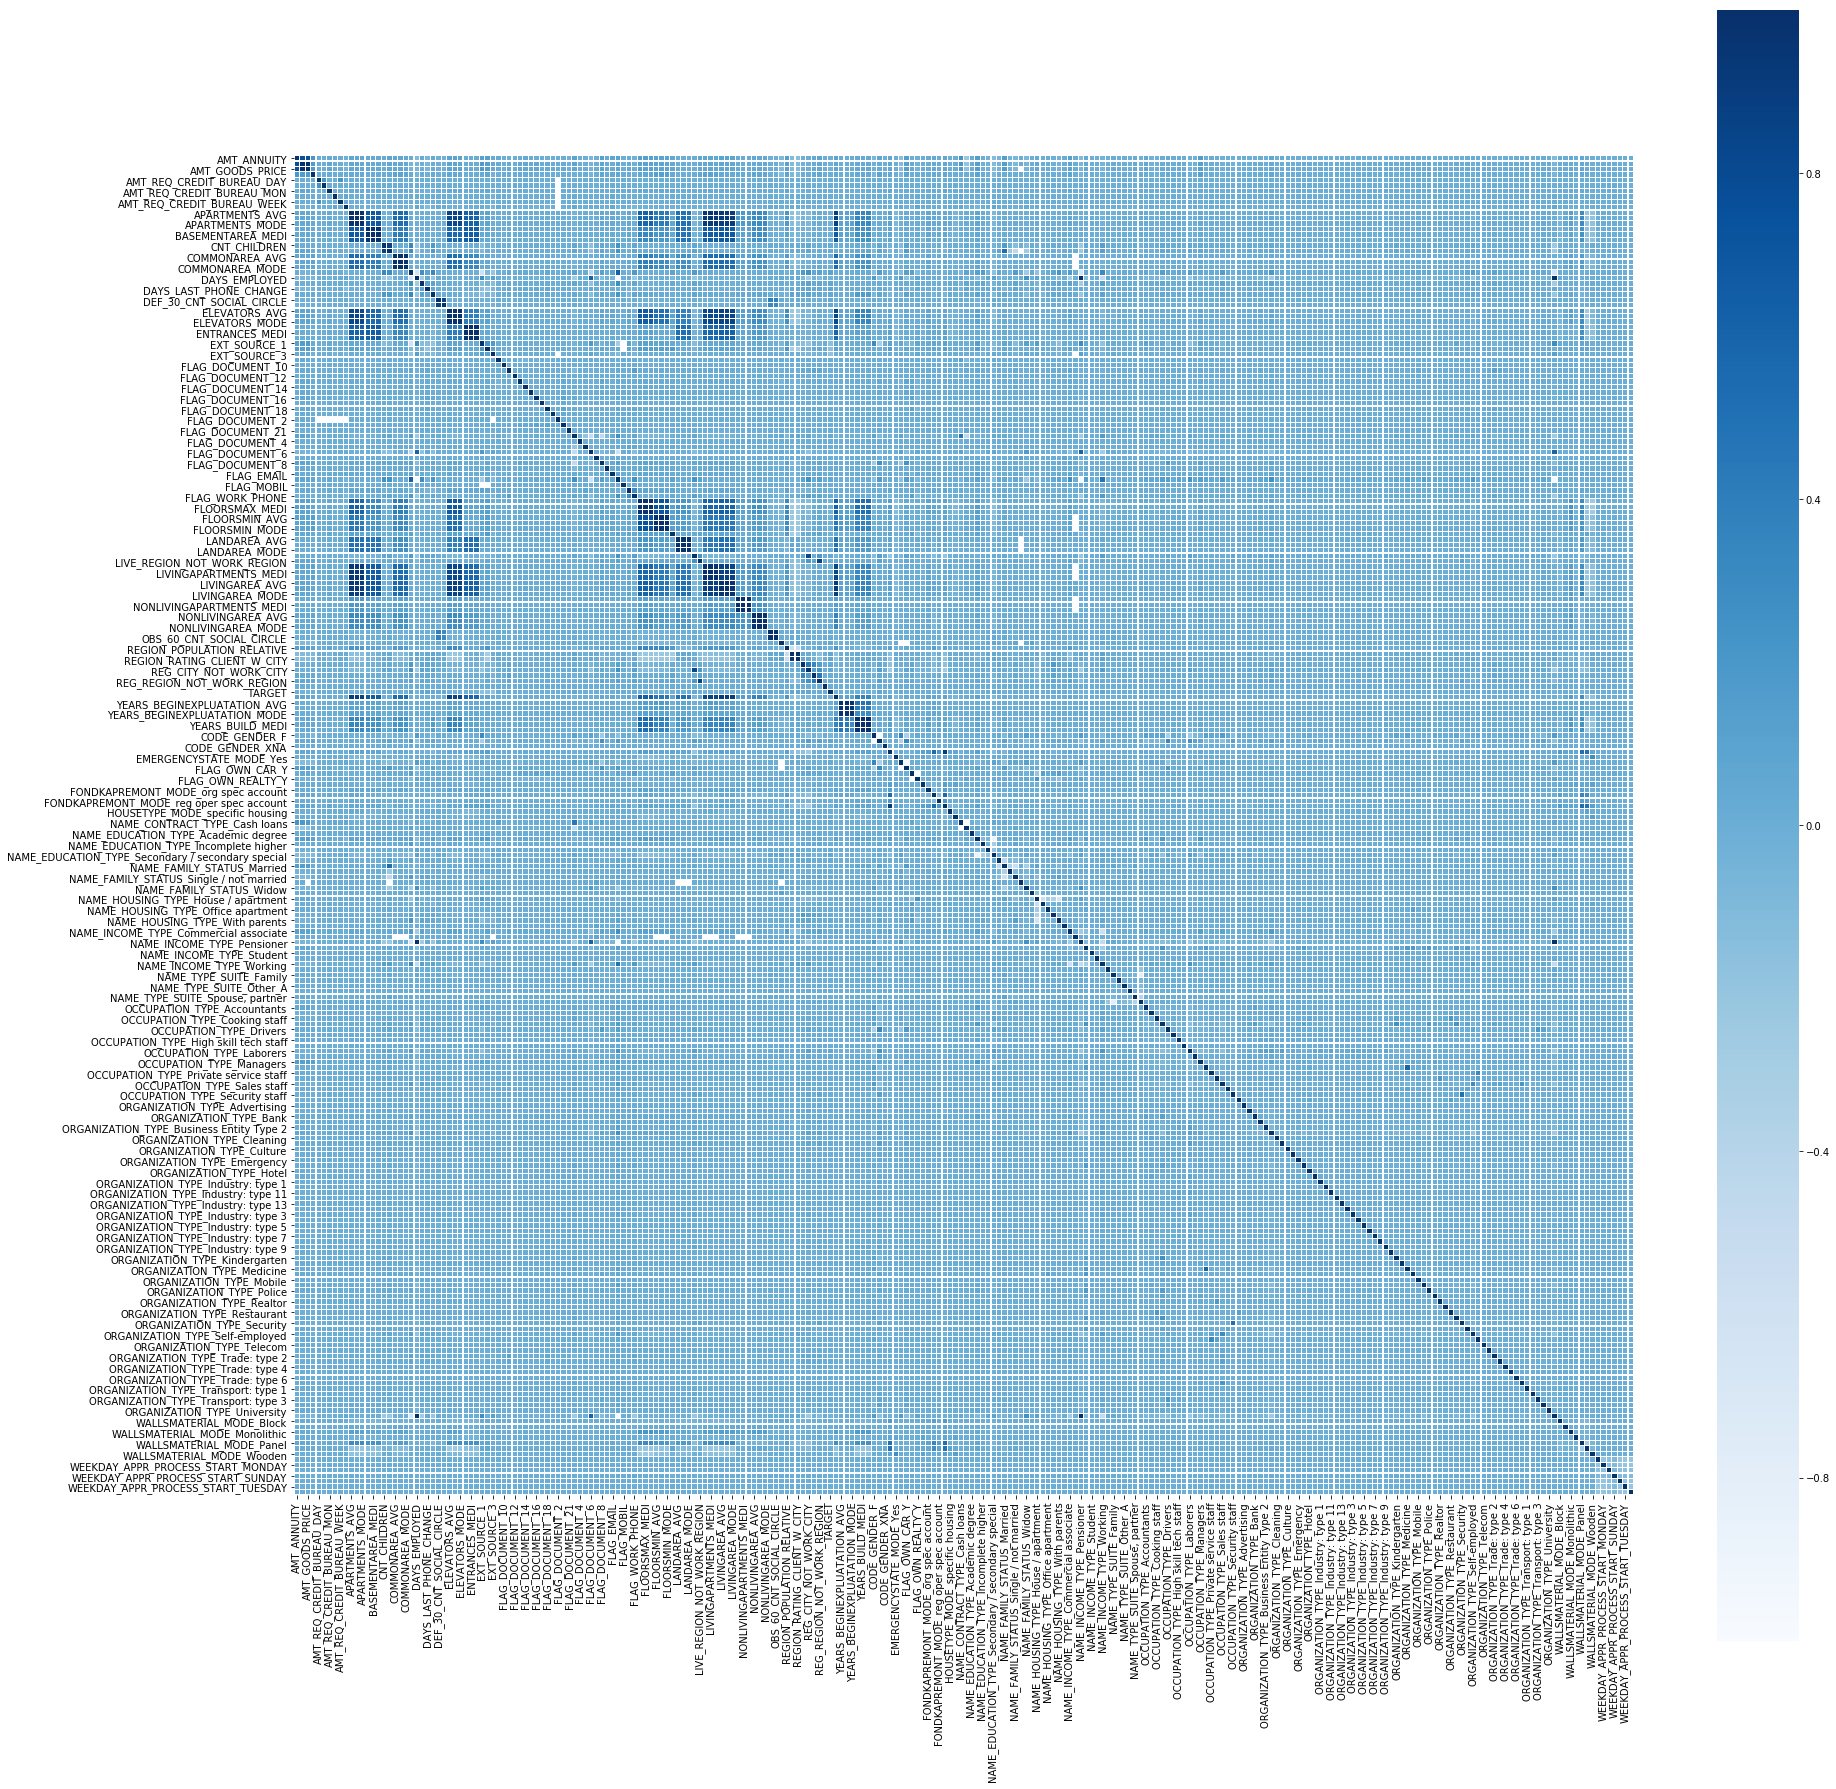

In [19]:
# create the heatmap

plt.figure(figsize=(30,30))
sns.heatmap(corr_mat, linewidth=0.1, square=True, cmap="Blues")

plt.show()

In [20]:
# split the concatenated dataset into the train dataset and the test dataset

train_input = new_train_test[0: train.shape[0]].copy()
print("train_inout shape is", train_input.shape)

test_input = new_train_test[train.shape[0]:].copy()
print("test_inout shape is", test_input.shape)

train_inout shape is (307511, 246)
test_inout shape is (48744, 246)


In [21]:
X = train_input.drop("TARGET",axis=1).values
y = train_input.loc[:,'TARGET'].values

In [22]:
X

array([[2.4700500e+04, 4.0659750e+05, 3.5100000e+05, ..., 0.0000000e+00,
        0.0000000e+00, 1.0000000e+00],
       [3.5698500e+04, 1.2935025e+06, 1.1295000e+06, ..., 0.0000000e+00,
        0.0000000e+00, 0.0000000e+00],
       [6.7500000e+03, 1.3500000e+05, 1.3500000e+05, ..., 0.0000000e+00,
        0.0000000e+00, 0.0000000e+00],
       ...,
       [2.9979000e+04, 6.7766400e+05, 5.8500000e+05, ..., 1.0000000e+00,
        0.0000000e+00, 0.0000000e+00],
       [2.0205000e+04, 3.7010700e+05, 3.1950000e+05, ..., 0.0000000e+00,
        0.0000000e+00, 1.0000000e+00],
       [4.9117500e+04, 6.7500000e+05, 6.7500000e+05, ..., 1.0000000e+00,
        0.0000000e+00, 0.0000000e+00]])

In [23]:
y

array([1., 0., 0., ..., 0., 1., 0.])

In [24]:
# trainとtestに分ける
#X_train, X_test, y_train, y_test = train_test_split(
#     X, y, test_size=0.3)
#print(len(X_train)/len(X))

In [25]:
# まずLithgbmのパイプラインを作る

lgb_train = lgb.Dataset(X,y)

In [26]:
lgb_eval = lgb.Dataset(X, y, reference=lgb_train)

In [27]:
lgb_params = {'objective':'binary',
               'boosting_type': 'rf',
               'subsample': 0.623,
               'colsample_bytree': 0.7,
               'num_leaves': 127,
               'max_depth': 8,
               'seed': 99,
               'bagging_freq': 1,
               'n_jobs': 4}

In [28]:
model = lgb.train(lgb_params, lgb_train, valid_sets=lgb_eval)

[1]	valid_0's binary_logloss: 0.262326
[2]	valid_0's binary_logloss: 0.25312
[3]	valid_0's binary_logloss: 0.251118
[4]	valid_0's binary_logloss: 0.250335
[5]	valid_0's binary_logloss: 0.250268
[6]	valid_0's binary_logloss: 0.250072
[7]	valid_0's binary_logloss: 0.249893
[8]	valid_0's binary_logloss: 0.249758
[9]	valid_0's binary_logloss: 0.249673
[10]	valid_0's binary_logloss: 0.249562
[11]	valid_0's binary_logloss: 0.249642
[12]	valid_0's binary_logloss: 0.24955
[13]	valid_0's binary_logloss: 0.249641
[14]	valid_0's binary_logloss: 0.249725
[15]	valid_0's binary_logloss: 0.249621
[16]	valid_0's binary_logloss: 0.249718
[17]	valid_0's binary_logloss: 0.249586
[18]	valid_0's binary_logloss: 0.24948
[19]	valid_0's binary_logloss: 0.249417
[20]	valid_0's binary_logloss: 0.249535
[21]	valid_0's binary_logloss: 0.249576
[22]	valid_0's binary_logloss: 0.249498
[23]	valid_0's binary_logloss: 0.249422
[24]	valid_0's binary_logloss: 0.24936
[25]	valid_0's binary_logloss: 0.24932
[26]	valid_0's

In [29]:
y_pred = model.predict(X)

In [30]:
# predict train_data

y_pred

array([0.352796  , 0.04778548, 0.06785813, ..., 0.07383127, 0.06623574,
       0.0831377 ])

In [31]:
# predict  test_data
y_test_pred = model.predict(test_input.values)

In [32]:
y_test_pred

array([0.06486488, 0.08909712, 0.03746819, ..., 0.06019668, 0.06904975,
       0.13670507])

In [33]:
test_input.values

array([[2.05605e+04, 5.68800e+05, 4.50000e+05, ..., 0.00000e+00,
        1.00000e+00, 0.00000e+00],
       [1.73700e+04, 2.22768e+05, 1.80000e+05, ..., 0.00000e+00,
        0.00000e+00, 0.00000e+00],
       [6.97770e+04, 6.63264e+05, 6.30000e+05, ..., 0.00000e+00,
        0.00000e+00, 0.00000e+00],
       ...,
       [3.32055e+04, 3.15000e+05, 3.15000e+05, ..., 0.00000e+00,
        0.00000e+00, 1.00000e+00],
       [2.51280e+04, 4.50000e+05, 4.50000e+05, ..., 0.00000e+00,
        0.00000e+00, 0.00000e+00],
       [2.47095e+04, 3.12768e+05, 2.70000e+05, ..., 0.00000e+00,
        1.00000e+00, 0.00000e+00]])

In [34]:
#y_test_pred2 = best_param_model.predict(test_input.values)
#y_test_pred2.shape

In [35]:
#sub = pd.read_csv('sample_submission.csv')
#sub.shape

In [36]:
#sub['TARGET'] = y_test_pred2

In [37]:
#sub.to_csv('pipeline_.csv', index=False)

In [38]:
#sub

In [39]:
# def auc
def make_roc_curve (y_true, y_pred):
    from sklearn.metrics import roc_curve
    from sklearn import metrics

    fpr, tpr, thresholds = roc_curve(y_true, y_pred, pos_label=1)
    auc = metrics.auc(fpr, tpr)
    print('auc{}'.format(auc))

    # ROC
    # ROC曲線をプロット
    plt.plot(fpr, tpr, label='ROC curve (area = %.2f)'%auc)
    plt.legend()
    plt.title('ROC curve')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.grid(True)
    return auc
  

auc0.7570752634565502


0.7570752634565502

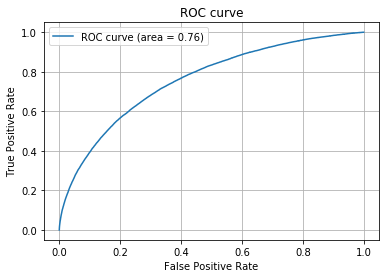

In [40]:
make_roc_curve(y, y_pred)

### Task 1 CrossVaridation

TRAIN: [ 61503  61504  61505 ... 307508 307509 307510] TEST: [    0     1     2 ... 61500 61501 61502]
[1]	valid_0's binary_logloss: 0.262819
[2]	valid_0's binary_logloss: 0.258418
[3]	valid_0's binary_logloss: 0.253094
[4]	valid_0's binary_logloss: 0.251167
[5]	valid_0's binary_logloss: 0.250436
[6]	valid_0's binary_logloss: 0.250061
[7]	valid_0's binary_logloss: 0.249928
[8]	valid_0's binary_logloss: 0.249589
[9]	valid_0's binary_logloss: 0.249368
[10]	valid_0's binary_logloss: 0.249261
[11]	valid_0's binary_logloss: 0.249193
[12]	valid_0's binary_logloss: 0.249304
[13]	valid_0's binary_logloss: 0.24931
[14]	valid_0's binary_logloss: 0.249456
[15]	valid_0's binary_logloss: 0.249328
[16]	valid_0's binary_logloss: 0.249376
[17]	valid_0's binary_logloss: 0.249311
[18]	valid_0's binary_logloss: 0.249335
[19]	valid_0's binary_logloss: 0.249401
[20]	valid_0's binary_logloss: 0.249307
[21]	valid_0's binary_logloss: 0.249224
[22]	valid_0's binary_logloss: 0.249313
[23]	valid_0's binary_loglo

auc0.7412137736144492
TRAIN: [     0      1      2 ... 307508 307509 307510] TEST: [123005 123006 123007 ... 184504 184505 184506]
[1]	valid_0's binary_logloss: 0.262873
[2]	valid_0's binary_logloss: 0.252217
[3]	valid_0's binary_logloss: 0.250013
[4]	valid_0's binary_logloss: 0.249275
[5]	valid_0's binary_logloss: 0.249135
[6]	valid_0's binary_logloss: 0.248891
[7]	valid_0's binary_logloss: 0.248623
[8]	valid_0's binary_logloss: 0.248485
[9]	valid_0's binary_logloss: 0.248402
[10]	valid_0's binary_logloss: 0.248282
[11]	valid_0's binary_logloss: 0.248345
[12]	valid_0's binary_logloss: 0.248185
[13]	valid_0's binary_logloss: 0.248225
[14]	valid_0's binary_logloss: 0.248332
[15]	valid_0's binary_logloss: 0.248193
[16]	valid_0's binary_logloss: 0.248276
[17]	valid_0's binary_logloss: 0.248151
[18]	valid_0's binary_logloss: 0.248048
[19]	valid_0's binary_logloss: 0.247955
[20]	valid_0's binary_logloss: 0.248062
[21]	valid_0's binary_logloss: 0.248119
[22]	valid_0's binary_logloss: 0.24805

auc0.7438785606625449
TRAIN: [     0      1      2 ... 246006 246007 246008] TEST: [246009 246010 246011 ... 307508 307509 307510]
[1]	valid_0's binary_logloss: 0.262852
[2]	valid_0's binary_logloss: 0.253895
[3]	valid_0's binary_logloss: 0.25278
[4]	valid_0's binary_logloss: 0.25104
[5]	valid_0's binary_logloss: 0.250225
[6]	valid_0's binary_logloss: 0.249789
[7]	valid_0's binary_logloss: 0.249897
[8]	valid_0's binary_logloss: 0.249999
[9]	valid_0's binary_logloss: 0.249717
[10]	valid_0's binary_logloss: 0.249504
[11]	valid_0's binary_logloss: 0.24935
[12]	valid_0's binary_logloss: 0.249441
[13]	valid_0's binary_logloss: 0.249562
[14]	valid_0's binary_logloss: 0.24941
[15]	valid_0's binary_logloss: 0.249332
[16]	valid_0's binary_logloss: 0.249405
[17]	valid_0's binary_logloss: 0.249302
[18]	valid_0's binary_logloss: 0.2492
[19]	valid_0's binary_logloss: 0.24915
[20]	valid_0's binary_logloss: 0.249232
[21]	valid_0's binary_logloss: 0.249143
[22]	valid_0's binary_logloss: 0.249112
[23]	

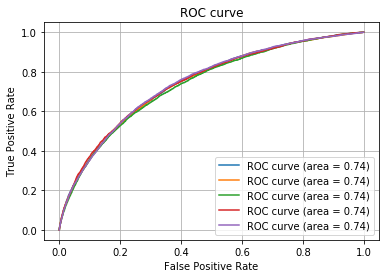

In [41]:
# XをCrossVaridationしてmodelを作成し汎化性能を見る
kf = KFold(n_splits = 5)
for train_index, test_index in kf.split(X):
    print("TRAIN:", train_index, "TEST:", test_index)
    X_train_cv, X_test_cv = X[train_index], X[test_index]
    y_train_cv, y_test_cv = y[train_index], y[test_index]
    lgb_train_cv = lgb.Dataset(X_train_cv,y_train_cv)
    lgb_eval_cv = lgb.Dataset(X_train_cv, y_train_cv, reference=lgb_train)
    model_cv = lgb.train(lgb_params, lgb_train_cv, valid_sets=lgb_eval_cv)
    y_test_pred_cv = model_cv.predict(X_test_cv)
    make_roc_curve(y_test_cv, y_test_pred_cv)

## Task2 grid search
optuna を使ってみる

In [42]:
# grid searchでなくてoptunaを使ってみる
import optuna
from sklearn.model_selection import train_test_split

array([[2.4700500e+04, 4.0659750e+05, 3.5100000e+05, ..., 0.0000000e+00,
        0.0000000e+00, 1.0000000e+00],
       [3.5698500e+04, 1.2935025e+06, 1.1295000e+06, ..., 0.0000000e+00,
        0.0000000e+00, 0.0000000e+00],
       [6.7500000e+03, 1.3500000e+05, 1.3500000e+05, ..., 0.0000000e+00,
        0.0000000e+00, 0.0000000e+00],
       ...,
       [2.9979000e+04, 6.7766400e+05, 5.8500000e+05, ..., 1.0000000e+00,
        0.0000000e+00, 0.0000000e+00],
       [2.0205000e+04, 3.7010700e+05, 3.1950000e+05, ..., 0.0000000e+00,
        0.0000000e+00, 1.0000000e+00],
       [4.9117500e+04, 6.7500000e+05, 6.7500000e+05, ..., 1.0000000e+00,
        0.0000000e+00, 0.0000000e+00]])

In [98]:
def objective(trial):
    
    train_x, test_x, train_y, test_y = train_test_split(X, y, test_size=0.2)
    dtrain = lgb.Dataset(train_x, label=train_y)
    dtest = lgb.Dataset(test_x, label=test_y)
        
    param = {'objective': 'binary', 'metric': 'binary_error', 'verbosity': -1,
             'boosting_type': trial.suggest_categorical('boosting', ['gbdt', 'dart', 'goss']),
             'num_leaves': trial.suggest_int('num_leaves', 10, 1000),
             'learning_rate': trial.suggest_loguniform('learning_rate', 1e-8, 1.0)
             }
    if param['boosting_type'] == 'dart':
        param['drop_rate'] = trial.suggest_loguniform('drop_rate', 1e-8, 1.0)
        param['skip_drop'] = trial.suggest_loguniform('skip_drop', 1e-8, 1.0)
    if param['boosting_type'] == 'goss':
        param['top_rate'] = trial.suggest_uniform('top_rate', 0.0, 1.0)
        param['other_rate'] = trial.suggest_uniform('other_rate', 0.0, 1.0 - param['top_rate'])
        # Add a callback for pruning.
    pruning_callback = optuna.integration.LightGBMPruningCallback(trial, 'binary_error')
    gbm = lgb.train(param, dtrain, valid_sets=[dtest], verbose_eval=False,
                    callbacks=[pruning_callback])
    preds = gbm.predict(test_x)
    pred_labels = np.rint(preds)
    auc = roc_auc_score(test_y, pred_labels)
    return 1.0 - auc

In [99]:
study = optuna.create_study(pruner=optuna.pruners.MedianPruner(n_warmup_steps=10))
study.optimize(objective, n_trials=100)

print('Number of finished trials: {}'.format(len(study.trials)))

print('Best trial:')
trial = study.best_trial

print('  Value: {}'.format(trial.value))

print('  Params: ')
for key, value in trial.params.items():
    print('    {}: {}'.format(key, value))

[I 2019-02-02 21:06:21,956] Finished a trial resulted in value: 0.5. Current best value is 0.5 with parameters: {'boosting': 'gbdt', 'num_leaves': 595, 'learning_rate': 0.000877344830090953}.
[I 2019-02-02 21:06:29,857] Finished a trial resulted in value: 0.47840081553624425. Current best value is 0.47840081553624425 with parameters: {'boosting': 'dart', 'num_leaves': 80, 'learning_rate': 0.32028794676549305, 'drop_rate': 0.00028434404508262043, 'skip_drop': 0.0001495192331654674}.
[I 2019-02-02 21:06:56,083] Finished a trial resulted in value: 0.5. Current best value is 0.47840081553624425 with parameters: {'boosting': 'dart', 'num_leaves': 80, 'learning_rate': 0.32028794676549305, 'drop_rate': 0.00028434404508262043, 'skip_drop': 0.0001495192331654674}.
[I 2019-02-02 21:07:19,001] Finished a trial resulted in value: 0.5. Current best value is 0.47840081553624425 with parameters: {'boosting': 'dart', 'num_leaves': 80, 'learning_rate': 0.32028794676549305, 'drop_rate': 0.00028434404508

Number of finished trials: 100
Best trial:
  Value: 0.47840081553624425
  Params: 
    boosting: dart
    num_leaves: 80
    learning_rate: 0.32028794676549305
    drop_rate: 0.00028434404508262043
    skip_drop: 0.0001495192331654674


In [103]:
# best params
best_lgb_params = {'objective': 'binary',
         'metric': 'binary_error', 
         'verbosity': -1,
         'boosting_type':'rf',
         'num_leaves': 80,
         'learning_rate': 0.32028794676549305,
         'subsample': 0.623,
         'colsample_bytree': 0.7,
         'max_depth': 8,
         'seed': 99,
         'bagging_freq': 1,
         'n_jobs': 4}

In [104]:
lgb_train = lgb.Dataset(X,y)

In [105]:
lgb_eval2 = lgb.Dataset(X, y, reference=lgb_train)

In [106]:
best_param_model = lgb.train(best_lgb_params, lgb_train, valid_sets=lgb_eval2)

[1]	valid_0's binary_error: 0.0808394
[2]	valid_0's binary_error: 0.080589
[3]	valid_0's binary_error: 0.0807126
[4]	valid_0's binary_error: 0.080667
[5]	valid_0's binary_error: 0.0806865
[6]	valid_0's binary_error: 0.0806963
[7]	valid_0's binary_error: 0.0807061
[8]	valid_0's binary_error: 0.080693
[9]	valid_0's binary_error: 0.0807158
[10]	valid_0's binary_error: 0.0807126
[11]	valid_0's binary_error: 0.0807158
[12]	valid_0's binary_error: 0.0807126
[13]	valid_0's binary_error: 0.0807223
[14]	valid_0's binary_error: 0.0807256
[15]	valid_0's binary_error: 0.0807256
[16]	valid_0's binary_error: 0.0807288
[17]	valid_0's binary_error: 0.0807256
[18]	valid_0's binary_error: 0.0807288
[19]	valid_0's binary_error: 0.0807288
[20]	valid_0's binary_error: 0.0807288
[21]	valid_0's binary_error: 0.0807288
[22]	valid_0's binary_error: 0.0807288
[23]	valid_0's binary_error: 0.0807256
[24]	valid_0's binary_error: 0.0807256
[25]	valid_0's binary_error: 0.0807256
[26]	valid_0's binary_error: 0.080728

In [107]:
y_pred_best_param_train = best_param_model.predict(X)
y_pred_best_param_train.shape

(307511,)

auc0.7494417584546584


0.7494417584546584

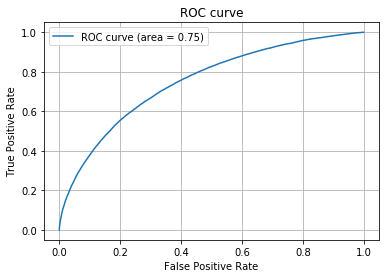

In [108]:
make_roc_curve(y, y_pred_best_param_train)

## best_parameterの方がauc高い

In [51]:
# parameter_table化
params_table = study.trials_dataframe()
params_table

trial_id                state     value             datetime_start  \
                                                                        
0         0      TrialState.FAIL       NaN 2019-02-02 13:43:53.809370   
1         1  TrialState.COMPLETE  0.500000 2019-02-02 13:43:55.588613   
2         2  TrialState.COMPLETE  0.500000 2019-02-02 13:44:41.650551   
3         3      TrialState.FAIL       NaN 2019-02-02 13:45:10.609259   
4         4  TrialState.COMPLETE  0.500000 2019-02-02 13:45:13.113614   
5         5  TrialState.COMPLETE  0.500000 2019-02-02 13:46:25.989961   
6         6      TrialState.FAIL       NaN 2019-02-02 13:47:19.147150   
7         7  TrialState.COMPLETE  0.484934 2019-02-02 13:47:21.364221   
8         8      TrialState.FAIL       NaN 2019-02-02 13:48:05.259161   
9         9    TrialState.PRUNED  0.082728 2019-02-02 13:48:07.728556   
10       10    TrialState.PRUNED  0.080598 2019-02-02 13:48:21.405974   
11       11      TrialState.FAIL       NaN 2019-02-02 13:48:33.527132   
12       12      TrialState.FAIL       NaN 2019-02-02 13:48:35.891810   
13       13    TrialState.PRUNED  0.081671 2019-02-02 13:48:38.330905   
14       14      TrialState.FAIL       NaN 2019-02-02 13:48:50.682282   
15       15    TrialState.PRUNED  0.081573 2019-02-02 13:48:53.120727   
16       16      TrialState.FAIL       NaN 2019-02-02 13:49:00.453149   
17       17      TrialState.FAIL       NaN 2019-02-02 13:49:02.860105   
18       18      TrialState.FAIL       NaN 2019-02-02 13:49:05.251882   
19       19      TrialState.FAIL       NaN 2019-02-02 13:49:07.664828   
20       20      TrialState.FAIL       NaN 2019-02-02 13:49:10.157160   
21       21      TrialState.FAIL       NaN 2019-02-02 13:49:12.730276   
22       22      TrialState.FAIL       NaN 2019-02-02 13:49:15.244554   
23       23      TrialState.FAIL       NaN 2019-02-02 13:49:17.707245   
24       24    TrialState.PRUNED  0.082045 2019-02-02 13:49:20.211594   
25       25      TrialState.FAIL       NaN 2019-02-02 13:49:32.288249   
26       26    TrialState.PRUNED  0.081102 2019-02-02 13:49:34.807264   
27       27    TrialState.PRUNED  0.080890 2019-02-02 13:49:44.906529   
28       28      TrialState.FAIL       NaN 2019-02-02 13:49:55.573992   
29       29      TrialState.FAIL       NaN 2019-02-02 13:49:58.044574   
..      ...                  ...       ...                        ...   
70       70      TrialState.FAIL       NaN 2019-02-02 13:55:30.259341   
71       71      TrialState.FAIL       NaN 2019-02-02 13:55:32.805530   
72       72      TrialState.FAIL       NaN 2019-02-02 13:55:35.276921   
73       73      TrialState.FAIL       NaN 2019-02-02 13:55:37.763269   
74       74      TrialState.FAIL       NaN 2019-02-02 13:55:40.227678   
75       75      TrialState.FAIL       NaN 2019-02-02 13:55:42.802796   
76       76      TrialState.FAIL       NaN 2019-02-02 13:55:45.320058   
77       77      TrialState.FAIL       NaN 2019-02-02 13:55:47.790450   
78       78      TrialState.FAIL       NaN 2019-02-02 13:55:50.269819   
79       79      TrialState.FAIL       NaN 2019-02-02 13:55:52.720337   
80       80      TrialState.FAIL       NaN 2019-02-02 13:55:55.207612   
81       81      TrialState.FAIL       NaN 2019-02-02 13:55:57.726873   
82       82      TrialState.FAIL       NaN 2019-02-02 13:56:00.205245   
83       83      TrialState.FAIL       NaN 2019-02-02 13:56:02.702626   
84       84      TrialState.FAIL       NaN 2019-02-02 13:56:05.170962   
85       85      TrialState.FAIL       NaN 2019-02-02 13:56:07.655316   
86       86      TrialState.FAIL       NaN 2019-02-02 13:56:09.906465   
87       87      TrialState.FAIL       NaN 2019-02-02 13:56:12.331811   
88       88      TrialState.FAIL       NaN 2019-02-02 13:56:14.233722   
89       89      TrialState.FAIL       NaN 2019-02-02 13:56:16.725461   
90       90      TrialState.FAIL       NaN 2019-02-02 13:56:19.277232   
91       91      TrialState.FAIL       NaN 2019-02-02 13:56:2

## 問題3 カーネルから考える
bestvoteのカーネルを参考にした
EDAを実行するときに常にデータ内の異常に注意する!
DAYS_BIRTH列の数値は、現在の融資申請に関連して記録されているため、負の値. 
DAYS_BIRTH列の値を-1を乗じて1年の日数で割り特徴量を増やせる年数で見ることができる
異常の処理に規則は設定されてないが、最も安全な方法の1つは、異常を欠損値に設定してから、機械学習の前にそれらを埋め込む（Imputationを使用して）ことである.
年齢カテゴリを5年ごとのビンにカットし,sns.kdeplotでターゲットが1の年齢とターゲットが0の年齢でどんな分布になっているか調べる.
それによって若い年代の方がローンを返済していないことがわかる.

## 問題4 高い汎化性能のモデル